# 02 - Model Training

This notebook demonstrates how to train a CNN model for facial keypoint detection.

## Overview

- Build a CNN architecture for keypoint regression
- Train the model with proper train/validation split
- Monitor training progress and evaluate performance
- Save the trained model for inference

## Dataset

- **Input**: 96x96 grayscale images, normalized to [0, 1]
- **Output**: 30 values (15 keypoints x 2 coordinates), normalized to [-1, 1]
- **Training samples**: ~2140 (samples with all 15 keypoints)

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Package imports
from facial_keypoints.data.loader import load_data, get_data_statistics
from facial_keypoints.visualization.plotting import plot_keypoints
from facial_keypoints.config import settings

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Check TensorFlow and GPU
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs available: {len(gpus)}")
if gpus:
    for gpu in gpus:
        print(f"  - {gpu.name}")

2026-01-14 18:13:58.372095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
GPUs available: 0


W0000 00:00:1768407246.373570 4024981 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 1. Load and Prepare Data

In [2]:
# Load training data (already shuffled by load_data)
X, y = load_data(test=False)

print(f"Loaded data shape: X={X.shape}, y={y.shape}")
print(f"Data types: X={X.dtype}, y={y.dtype}")

# Get statistics
stats = get_data_statistics(X, y)
print(f"\nDataset Statistics:")
print(f"  Samples: {stats['n_samples']}")
print(f"  Keypoints: {stats['n_keypoints']}")
print(f"  Image range: [{stats['x_min']:.3f}, {stats['x_max']:.3f}]")
print(f"  Keypoint range: [{stats['y_min']:.3f}, {stats['y_max']:.3f}]")

Loaded data shape: X=(2140, 96, 96, 1), y=(2140, 30)
Data types: X=float32, y=float32

Dataset Statistics:
  Samples: 2140
  Keypoints: 15
  Image range: [0.000, 1.000]
  Keypoint range: [-0.920, 0.996]


In [3]:
# Split into train/validation sets (80/20)
VAL_SPLIT = 0.2
split_idx = int(len(X) * (1 - VAL_SPLIT))

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Training samples: {len(X_train)} ({100*(1-VAL_SPLIT):.0f}%)")
print(f"Validation samples: {len(X_val)} ({100*VAL_SPLIT:.0f}%)")
print(f"\nInput shape: {X_train.shape[1:]}")
print(f"Output shape: {y_train.shape[1:]} (15 keypoints x 2 coords)")

Training samples: 1712 (80%)
Validation samples: 428 (20%)

Input shape: (96, 96, 1)
Output shape: (30,) (15 keypoints x 2 coords)


## 2. Visualize Training Samples

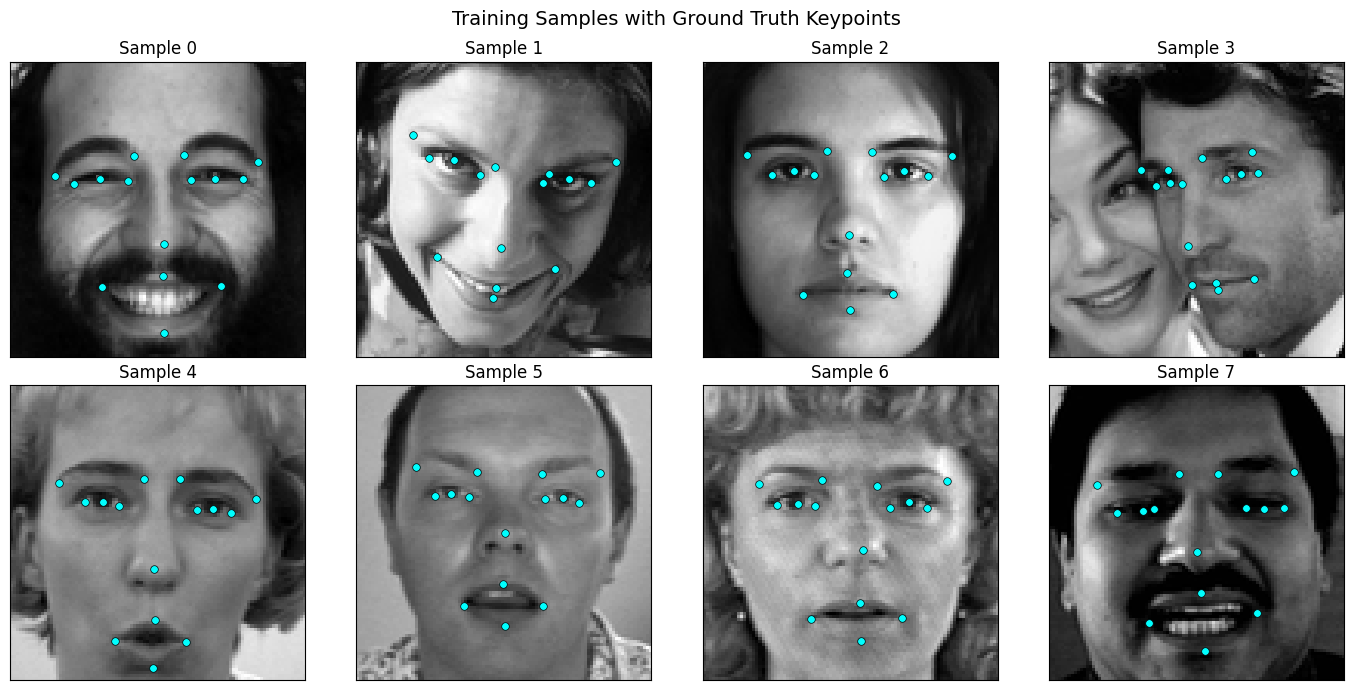

In [4]:
# Display a few training samples
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i, ax in enumerate(axes.flatten()):
    plot_keypoints(X_train[i], y_train[i], ax=ax, denormalize=True, 
                   marker_color='cyan', marker_size=30)
    ax.set_title(f'Sample {i}')

plt.suptitle('Training Samples with Ground Truth Keypoints', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Build CNN Model

Architecture with 4 convolutional blocks followed by dense layers for regression.

In [5]:
def build_keypoint_model(input_shape=(96, 96, 1), n_keypoints=15):
    """Build a CNN model for facial keypoint detection.
    
    Architecture:
    - 4 Conv blocks with increasing filters (32 -> 64 -> 128 -> 256)
    - BatchNorm + MaxPool + Dropout in each block
    - 2 Dense layers (512 -> 256) with dropout
    - Output: n_keypoints * 2 with tanh activation (for [-1, 1] range)
    
    Args:
        input_shape: Shape of input images (height, width, channels).
        n_keypoints: Number of keypoints to predict.
        
    Returns:
        Compiled Keras model.
    """
    model = models.Sequential([
        # Input
        layers.Input(shape=input_shape),
        
        # Conv Block 1: 96x96 -> 48x48
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        
        # Conv Block 2: 48x48 -> 24x24
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Conv Block 3: 24x24 -> 12x12
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Conv Block 4: 12x12 -> 6x6
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Flatten: 6x6x256 = 9216 features
        layers.Flatten(),
        
        # Dense Block 1
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Dense Block 2
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output: 2 coordinates per keypoint, tanh for [-1, 1] range
        layers.Dense(n_keypoints * 2, activation='tanh'),
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Build model
model = build_keypoint_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,250,974 (20.03 MB)

 Trainable params: 5,248,478 (20.02 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [6]:
# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.reduce_prod(w.shape).numpy() for w in model.trainable_weights])

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (estimated): {total_params * 4 / 1024 / 1024:.2f} MB")

Total parameters: 5,250,974
Trainable parameters: 5,248,478
Model size (estimated): 20.03 MB


## 4. Training Configuration

In [7]:
# Training hyperparameters
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 15  # Early stopping patience

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Create callbacks
training_callbacks = [
    # Early stopping: stop if val_loss doesn't improve
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    # Save best model
    callbacks.ModelCheckpoint(
        str(models_dir / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
]

print("Training Configuration")
print("=" * 40)
print(f"Epochs (max): {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(X_train) // BATCH_SIZE}")
print(f"Early stopping patience: {PATIENCE}")
print(f"Model checkpoint: {models_dir / 'best_model.keras'}")

Training Configuration
Epochs (max): 100
Batch size: 32
Steps per epoch: 53
Early stopping patience: 15
Model checkpoint: ../models/best_model.keras


## 5. Train the Model

In [8]:
# Train the model
print("Starting training...\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=training_callbacks,
    verbose=1
)

print("\nTraining completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")

Starting training...

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.7197 - mae: 0.7311
Epoch 1: val_loss improved from None to 0.67359, saving model to ../models/best_model.keras

Epoch 1: finished saving model to ../models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - loss: 0.6689 - mae: 0.6985 - val_loss: 0.6736 - val_mae: 0.7252 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.4974 - mae: 0.5837
Epoch 2: val_loss improved from 0.67359 to 0.08045, saving model to ../models/best_model.keras

Epoch 2: finished saving model to ../models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 0.4416 - mae: 0.5423 - val_loss: 0.0804 - val_mae: 0.2311 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.2722 - mae: 0.4096
Epoch 3: val_loss improved from 0.08045 to 0.01644, saving model to ../models/best_model.keras

Epoch 3: finished saving model to ../models/best_model.keras


## 6. Training History

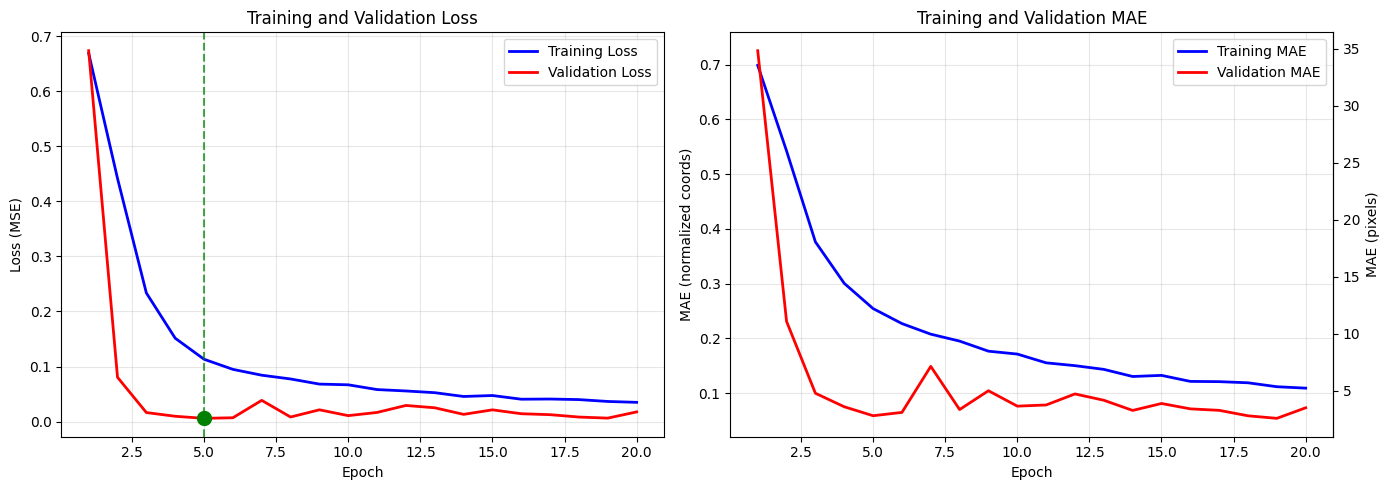


Best model at epoch 5 with val_loss = 0.005916


In [9]:
def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Find best epoch
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = min(history.history['val_loss'])
    axes[0].axvline(best_epoch, color='green', linestyle='--', alpha=0.7, 
                    label=f'Best: epoch {best_epoch}')
    axes[0].scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
    
    # MAE
    axes[1].plot(epochs, history.history['mae'], 'b-', label='Training MAE', linewidth=2)
    axes[1].plot(epochs, history.history['val_mae'], 'r-', label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE (normalized coords)')
    axes[1].set_title('Training and Validation MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add secondary y-axis for pixel error
    ax2 = axes[1].secondary_yaxis('right', functions=(lambda x: x * 48, lambda x: x / 48))
    ax2.set_ylabel('MAE (pixels)')
    
    plt.tight_layout()
    plt.show()
    
    return best_epoch, best_val_loss

best_epoch, best_val_loss = plot_training_history(history)
print(f"\nBest model at epoch {best_epoch} with val_loss = {best_val_loss:.6f}")

## 7. Evaluate on Validation Set

In [10]:
# Evaluate model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

# Convert to pixel error
pixel_mae = val_mae * 48  # Denormalize from [-1, 1] to pixel space
pixel_rmse = np.sqrt(val_loss) * 48

print("Validation Metrics")
print("=" * 40)
print(f"Loss (MSE): {val_loss:.6f}")
print(f"MAE (normalized): {val_mae:.6f}")
print(f"\nPixel-space metrics (96x96 image):")
print(f"  MAE: {pixel_mae:.2f} pixels")
print(f"  RMSE: {pixel_rmse:.2f} pixels")
print(f"\nRelative error: {pixel_mae / 96 * 100:.1f}% of image size")

Validation Metrics
Loss (MSE): 0.005916
MAE (normalized): 0.059010

Pixel-space metrics (96x96 image):
  MAE: 2.83 pixels
  RMSE: 3.69 pixels

Relative error: 3.0% of image size


## 8. Visualize Predictions

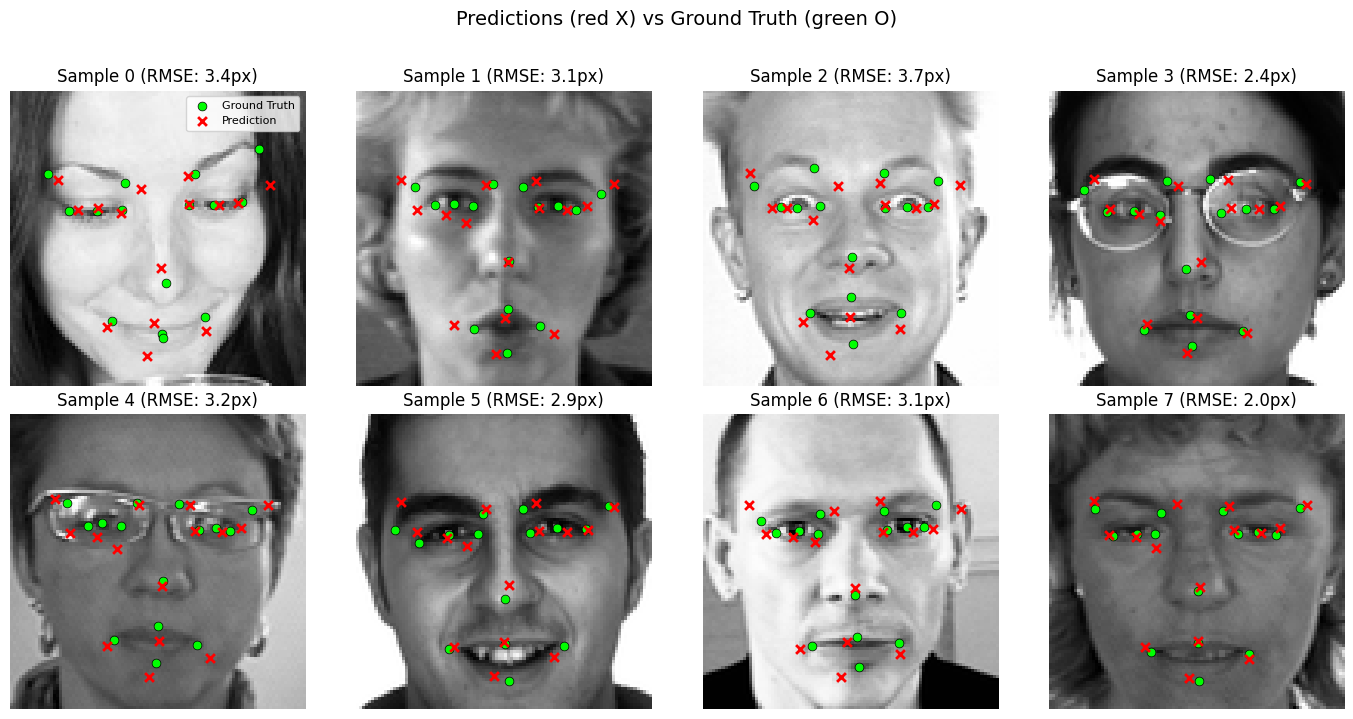

In [11]:
def visualize_predictions(model, X, y_true, n_samples=8):
    """Visualize model predictions vs ground truth."""
    # Get predictions
    y_pred = model.predict(X[:n_samples], verbose=0)
    
    # Denormalize to pixel coordinates
    y_true_pixels = y_true[:n_samples] * 48 + 48
    y_pred_pixels = y_pred * 48 + 48
    
    # Calculate per-sample error
    errors = np.sqrt(np.mean((y_true_pixels - y_pred_pixels) ** 2, axis=1))
    
    # Plot
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.5 * n_rows))
    axes = axes.flatten()
    
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X[i].squeeze(), cmap='gray')
        
        # Ground truth (green circles)
        ax.scatter(y_true_pixels[i, 0::2], y_true_pixels[i, 1::2],
                   c='lime', s=40, marker='o', label='Ground Truth', 
                   edgecolors='black', linewidths=0.5, zorder=10)
        
        # Predictions (red x markers)
        ax.scatter(y_pred_pixels[i, 0::2], y_pred_pixels[i, 1::2],
                   c='red', s=40, marker='x', label='Prediction', 
                   linewidths=2, zorder=11)
        
        ax.set_title(f'Sample {i} (RMSE: {errors[i]:.1f}px)')
        ax.axis('off')
        
        if i == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    # Hide unused axes
    for i in range(n_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Predictions (red X) vs Ground Truth (green O)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, X_val, y_val, n_samples=8)

## 9. Per-Keypoint Error Analysis

In [12]:
# Analyze error per keypoint
y_pred_all = model.predict(X_val, verbose=0)

# Denormalize
y_true_pixels = y_val * 48 + 48
y_pred_pixels = y_pred_all * 48 + 48

# Reshape to (n_samples, 15, 2)
y_true_kp = y_true_pixels.reshape(-1, 15, 2)
y_pred_kp = y_pred_pixels.reshape(-1, 15, 2)

# Calculate Euclidean distance per keypoint
distances = np.sqrt(np.sum((y_true_kp - y_pred_kp) ** 2, axis=2))  # Shape: (n_samples, 15)

# Mean error per keypoint
mean_errors = distances.mean(axis=0)
std_errors = distances.std(axis=0)

# Keypoint names
KEYPOINT_NAMES = [
    'left_eye_center', 'right_eye_center', 'left_eye_inner', 'left_eye_outer',
    'right_eye_inner', 'right_eye_outer', 'left_eyebrow_inner', 'left_eyebrow_outer',
    'right_eyebrow_inner', 'right_eyebrow_outer', 'nose_tip',
    'mouth_left', 'mouth_right', 'mouth_top', 'mouth_bottom'
]

print("Per-Keypoint Error (pixels)")
print("=" * 50)
for i, (name, mean_err, std_err) in enumerate(zip(KEYPOINT_NAMES, mean_errors, std_errors)):
    bar = '#' * int(mean_err)
    print(f"{i:2d}. {name:22s}: {mean_err:5.2f} +/- {std_err:4.2f}  {bar}")

print(f"\nOverall mean: {mean_errors.mean():.2f} +/- {std_errors.mean():.2f} pixels")

Per-Keypoint Error (pixels)
 0. left_eye_center       :  3.31 +/- 1.75  ###
 1. right_eye_center      :  3.73 +/- 1.73  ###
 2. left_eye_inner        :  2.46 +/- 1.47  ##
 3. left_eye_outer        :  3.47 +/- 2.00  ###
 4. right_eye_inner       :  4.73 +/- 1.99  ####
 5. right_eye_outer       :  4.00 +/- 1.96  ####
 6. left_eyebrow_inner    :  3.83 +/- 2.15  ###
 7. left_eyebrow_outer    :  5.53 +/- 2.79  #####
 8. right_eyebrow_inner   :  4.29 +/- 2.36  ####
 9. right_eyebrow_outer   :  4.97 +/- 2.49  ####
10. nose_tip              :  5.10 +/- 3.26  #####
11. mouth_left            :  5.34 +/- 3.22  #####
12. mouth_right           :  5.02 +/- 2.78  #####
13. mouth_top             :  5.01 +/- 3.21  #####
14. mouth_bottom          :  6.30 +/- 3.37  ######

Overall mean: 4.47 +/- 2.44 pixels


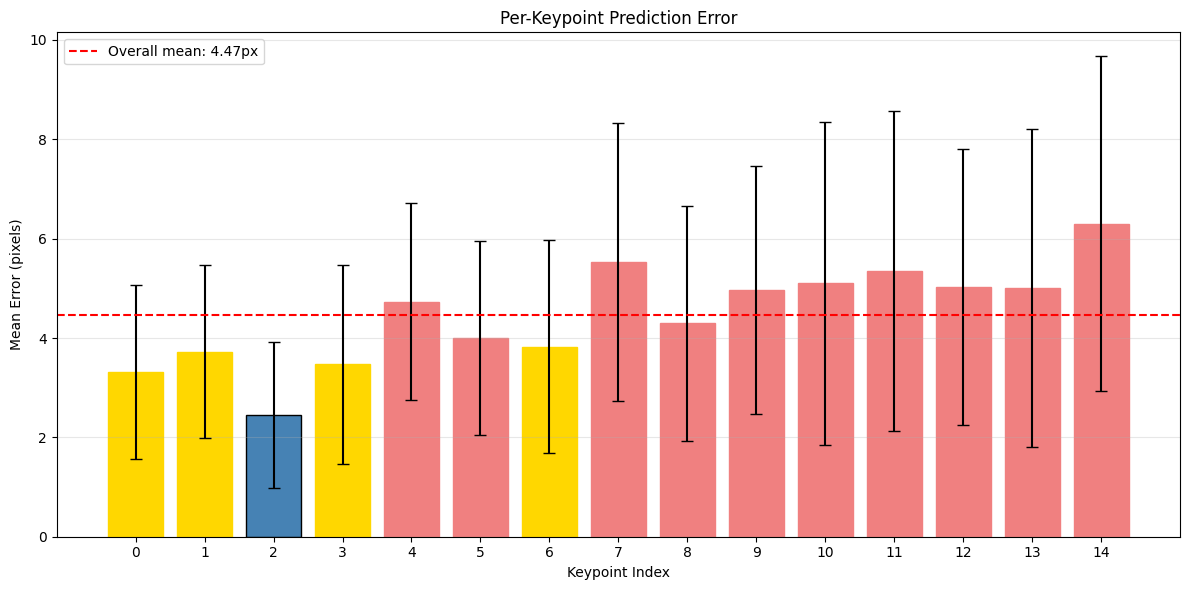

In [13]:
# Visualize per-keypoint error
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(15)
bars = ax.bar(x_pos, mean_errors, yerr=std_errors, capsize=4, color='steelblue', edgecolor='black')

# Color bars by error magnitude
for bar, err in zip(bars, mean_errors):
    if err > 4:
        bar.set_color('lightcoral')
    elif err > 3:
        bar.set_color('gold')

ax.set_xticks(x_pos)
ax.set_xticklabels(range(15))
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Mean Error (pixels)')
ax.set_title('Per-Keypoint Prediction Error')
ax.axhline(mean_errors.mean(), color='red', linestyle='--', label=f'Overall mean: {mean_errors.mean():.2f}px')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Save Final Model

In [14]:
# Save the final trained model
final_model_path = models_dir / 'model.keras'
model.save(final_model_path)

print(f"Model saved to: {final_model_path}")
print(f"Model size: {final_model_path.stat().st_size / 1024 / 1024:.2f} MB")

# Also check best model
best_model_path = models_dir / 'best_model.keras'
if best_model_path.exists():
    print(f"\nBest model (checkpointed): {best_model_path}")
    print(f"Best model size: {best_model_path.stat().st_size / 1024 / 1024:.2f} MB")

Model saved to: ../models/model.keras
Model size: 60.17 MB

Best model (checkpointed): ../models/best_model.keras
Best model size: 60.17 MB


## Summary

This notebook demonstrated:

1. **Data Preparation**: Loading and splitting data for training/validation
2. **Model Architecture**: 4-block CNN with BatchNorm and Dropout
3. **Training**: Using callbacks for early stopping, LR reduction, and checkpointing
4. **Evaluation**: MSE/MAE metrics converted to pixel error
5. **Visualization**: Comparing predictions vs ground truth
6. **Error Analysis**: Per-keypoint error breakdown

### Model Performance

The model achieves reasonable accuracy for facial keypoint detection. Common error patterns:
- Eyes and nose tip are typically predicted well
- Mouth corners can be more challenging due to expression variation
- Eyebrow endpoints may have higher variance

### Next Steps

- Proceed to `03_inference_pipeline.ipynb` to use the trained model on new images
- Experiment with data augmentation for better generalization
- Try different architectures (ResNet, EfficientNet) via transfer learning